In [3]:
import luigi
import requests
import json
from pymongo import MongoClient
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler  # Add this import statement
import http.client
import json
import pandas as pd
from pymongo import MongoClient
from sklearn.preprocessing import MinMaxScaler  # Add this import statement
from scipy import stats
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# Data Uploading
1)Drugs Over Dose,
2)DeathRelatedDrug,
3)AppointmentDetails

In [4]:


class FetchAPIData(luigi.Task):
    """
    Task to fetch data from a URL and save to a file.
    """
    file_name = luigi.Parameter()
    data_url = luigi.Parameter()  # This will be the URL where the JSON data is stored

    def run(self):
        # Fetch data from URL
        response = requests.get(self.data_url)
        data = response.json()  # Parse JSON data directly from response
        
        # Save data to a file
        with self.output().open('w') as f:
            json.dump(data, f, indent=4)
        print(f"Data successfully saved to {self.file_name}")

    def output(self):
        return luigi.LocalTarget(self.file_name)

class UploadDataToMongoDB(luigi.Task):
    """
    Task to upload data from a file to MongoDB.
    """
    file_name = luigi.Parameter()
    db_name = luigi.Parameter()
    collection_name = luigi.Parameter()
    file_type = luigi.Parameter(default='json')

    def requires(self):
        return FetchAPIData(
            file_name=self.file_name, 
            data_url="https://raw.githubusercontent.com/x22247734/HealthCareAnalystData/main/drugs_overdose_data.json"
        )

    def run(self):
        client = MongoClient('mongodb://localhost:27017/')
        db = client[self.db_name]
        collection = db[self.collection_name]
        
        try:
            with self.input().open('r') as file:
                if self.file_type == 'json':
                    data = json.load(file)
                elif self.file_type == 'csv':
                    df = pd.read_csv(file)
                    data = df.to_dict('records')
                else:
                    raise ValueError("Unsupported file type. Use 'json' or 'csv'.")
            
            if isinstance(data, list):
                collection.insert_many(data)
            else:
                collection.insert_one(data)
            
            print(f"Data successfully uploaded to MongoDB in the '{self.collection_name}' collection")
        except Exception as e:
            print(f"Failed to upload data to MongoDB from file {self.file_name}: {e}")

    def output(self):
        return luigi.LocalTarget(self.file_name + ".done")

# Example usage within a Luigi scheduler:
if __name__ == '__main__':
    luigi.build([
        UploadDataToMongoDB(
            file_name='drug_overdose.json', 
            db_name='HealthCare', 
            collection_name='DrugsOverDose', 
            file_type='json'
        ),
        UploadDataToMongoDB(
            file_name='DeathReleatedDrug.json', 
            db_name='HealthCare', 
            collection_name='DeathRelatedDrug', 
            file_type='json'
        ),
        UploadDataToMongoDB(
            file_name='appointment_details.csv', 
            db_name='HealthCare', 
            collection_name='AppointmentDetails', 
            file_type='csv'
        )
    ])


DEBUG: Checking if UploadDataToMongoDB(file_name=drug_overdose.json, db_name=HealthCare, collection_name=DrugsOverDose, file_type=json) is complete
DEBUG: Checking if FetchAPIData(file_name=drug_overdose.json, data_url=https://raw.githubusercontent.com/x22247734/HealthCareAnalystData/main/drugs_overdose_data.json) is complete
INFO: Informed scheduler that task   UploadDataToMongoDB_DrugsOverDose_HealthCare_drug_overdose_js_00f5bb15d1   has status   PENDING
INFO: Informed scheduler that task   FetchAPIData_https___raw_gith_drug_overdose_js_4e7f65c608   has status   DONE
DEBUG: Checking if UploadDataToMongoDB(file_name=DeathReleatedDrug.json, db_name=HealthCare, collection_name=DeathRelatedDrug, file_type=json) is complete
DEBUG: Checking if FetchAPIData(file_name=DeathReleatedDrug.json, data_url=https://raw.githubusercontent.com/x22247734/HealthCareAnalystData/main/drugs_overdose_data.json) is complete
INFO: Informed scheduler that task   UploadDataToMongoDB_DeathRelatedDrug_HealthCare_

Data successfully uploaded to MongoDB in the 'DrugsOverDose' collection
Data successfully uploaded to MongoDB in the 'DeathRelatedDrug' collection


INFO: [pid 88985] Worker Worker(salt=1380234225, workers=1, host=Priyankas-MacBook-Pro.local, username=priyankabundela, pid=88985) done      UploadDataToMongoDB(file_name=appointment_details.csv, db_name=HealthCare, collection_name=AppointmentDetails, file_type=csv)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   UploadDataToMongoDB_AppointmentDetai_HealthCare_appointment_deta_cdc625b9c3   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=1380234225, workers=1, host=Priyankas-MacBook-Pro.local, username=priyankabundela, pid=88985) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 6 tasks of which:
* 3 complete ones were encountered:
    - 3 FetchAPIData(file_name=DeathReleatedDrug.json, data_url=https://raw.githubusercontent.com/x22247734/HealthCareAnalystData/main/drugs_overdose_data.json) ...
* 3 ran 

Data successfully uploaded to MongoDB in the 'AppointmentDetails' collection


# DataSet 1:  Drug Overdose Mortality: A Data-Driven Public Health Strategy
#### Author:Priyanka Bundela 
x22247734@student.ncirl.ie

### ETL Process:
Retrieve Data from MongoDB:
Data Extraction from Mongo DB - Drug Over Dose

In [309]:
def extract_and_transform_data_from_mongodb(database_name, collection_name):
    client = MongoClient('localhost', 27017)
    database = client[database_name]
    collection = database[collection_name]
    
    # Extract all documents from the collection
    documents = collection.find()
    
    # Create a list of dictionaries (each document is a dictionary)
    data_list = list(documents)
    
    return data_list

# Replace 'HealthCare' and 'DrugsOverDose' with your actual database and collection names
data_list = extract_and_transform_data_from_mongodb('HealthCare', 'DrugsOverDose')

# Create a pandas DataFrame from the list of records
df = pd.DataFrame(data_list)



In [310]:
df.describe()

,panel_num,unit_num,stub_name_num,stub_label_num,year,year_num,age_num
count,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000
mean,2.500000,1.578035,3.028902,3.383006,2008.664740,10.664740,1.354913
std,1.707962,0.493913,1.447036,1.526819,5.849512,5.849512,0.301459
min,0.000000,1.000000,0.000000,0.100000,1999.000000,1.000000,1.100000
25%,1.000000,1.000000,2.000000,2.100000,2004.000000,6.000000,1.100000
50%,2.500000,2.000000,3.000000,3.220000,2009.000000,11.000000,1.200000
75%,4.000000,2.000000,4.000000,4.600000,2014.000000,16.000000,1.600000
max,5.000000,2.000000,5.000000,5.930000,2018.000000,20.000000,1.910000


In [311]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6228 entries, 0 to 6227
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             6228 non-null   object 
 1   indicator       6228 non-null   object 
 2   panel           6228 non-null   object 
 3   panel_num       6228 non-null   int64  
 4   unit            6228 non-null   object 
 5   unit_num        6228 non-null   int64  
 6   stub_name       6228 non-null   object 
 7   stub_name_num   6228 non-null   int64  
 8   stub_label      6228 non-null   object 
 9   stub_label_num  6228 non-null   float64
 10  year            6228 non-null   int64  
 11  year_num        6228 non-null   int64  
 12  age             6228 non-null   object 
 13  age_num         6228 non-null   float64
 14  estimate        6228 non-null   object 
 15  flag            6228 non-null   object 
dtypes: float64(2), int64(5), object(9)
memory usage: 778.6+ KB


In [312]:
df.duplicated().sum()

0

In [313]:
df.isna().sum()

_id               0
indicator         0
panel             0
panel_num         0
unit              0
unit_num          0
stub_name         0
stub_name_num     0
stub_label        0
stub_label_num    0
year              0
year_num          0
age               0
age_num           0
estimate          0
flag              0
dtype: int64

### Data Pre-processing:

In [314]:
# Filter out other death causes, keep "All drug overdose" only
df = df.loc[df["panel"] == "All drug overdose deaths"]

In [315]:
count = df.loc[df["panel"] == "All drug overdose deaths"].shape[0]
print("Count:", count)


Count: 1038


In [316]:
# d1 dataframe is age-adjusted data
d1 = df.loc[df["unit_num"] == 1]

# d2 dataframe is crude data
d2 = df.loc[df["unit_num"] == 2]

# Get value counts for 'stub_name' in the age-adjusted DataFrame d1
d1_stub_name_counts = d1['stub_name'].value_counts()
d2_stub_name_counts = d2['stub_name'].value_counts()

# Display the value counts
print(d1_stub_name_counts)

Sex and race and Hispanic origin                  200
Sex and race                                      160
Sex                                                40
Total                                              20
Sex and race and Hispanic origin (single race)     12
Sex and race (single race)                          6
Name: stub_name, dtype: int64


In [317]:
# Display the value counts
print(d2_stub_name_counts)

Sex and age    360
Age            180
Sex             40
Total           20
Name: stub_name, dtype: int64


### Data Transformation:

In [318]:
# Change DATE type from int64 to DateTime
df['year'] = pd.to_datetime(df['year'], format = '%Y')

# Remove rows that has ESTIMATE = NaN
df.dropna(subset = ['estimate'], inplace = True)

In [319]:
    # Convert 'estimate' to numeric type, coerce errors will turn non-convertible types to NaN
    print("Converting 'estimate' to numeric type...")
    df['estimate'] = pd.to_numeric(df['estimate'], errors='coerce')

    # Normalize the 'estimate' column
    print("Normalizing the 'estimate' column...")
    scaler = MinMaxScaler()
    df['normalized_estimate'] = scaler.fit_transform(df[['estimate']])
    print("Normalization complete.")



    # Styling the DataFrame for better visualization
    styled_df = df.style.set_table_styles(
        [{'selector': 'tr:hover',
          'props': [('background-color', 'yellow')]},
         {'selector': 'th',
          'props': [('background-color', 'lightblue'),
                    ('color', 'black'),
                    ('border-style', 'solid'),
                    ('border-width', '1px'),
                    ('border-color', 'black')]},
         {'selector': 'td',
          'props': [('border-style', 'solid'),
                    ('border-width', '1px'),
                    ('border-color', 'black')]}
        ]).set_properties(**{'background-color': 'white', 'color': 'black'}).hide(axis='index')

    # Display the styled DataFrame
    styled_df

Converting 'estimate' to numeric type...
Normalizing the 'estimate' column...
Normalization complete.


### Exploratory Data Analysis (EDA):

In [320]:
summary = df.describe()
print(summary)

       panel_num     unit_num  stub_name_num  stub_label_num     year_num  \
count     1038.0  1038.000000    1038.000000     1038.000000  1038.000000   
mean         0.0     1.578035       3.028902        3.383006    10.664740   
std          0.0     0.494111       1.447617        1.527433     5.851862   
min          0.0     1.000000       0.000000        0.100000     1.000000   
25%          0.0     1.000000       2.000000        2.125000     6.000000   
50%          0.0     2.000000       3.000000        3.220000    11.000000   
75%          0.0     2.000000       4.000000        4.600000    16.000000   
max          0.0     2.000000       5.000000        5.930000    20.000000   

           age_num     estimate  normalized_estimate  
count  1038.000000  1037.000000          1037.000000  
mean      1.354913    10.940212             0.200004  
std       0.301580     9.165554             0.169106  
min       1.100000     0.100000             0.000000  
25%       1.100000     3.900000

In [321]:
# Check for missing values (null values or NaNs)
print("Missing Values:", df.isna().sum())

Missing Values: _id                    0
indicator              0
panel                  0
panel_num              0
unit                   0
unit_num               0
stub_name              0
stub_name_num          0
stub_label             0
stub_label_num         0
year                   0
year_num               0
age                    0
age_num                0
estimate               1
flag                   0
normalized_estimate    1
dtype: int64


In [322]:
# Check missing values in 'estimate' column
missing_values_estimate = df['estimate'].isnull().sum()

# Output the number of missing values in 'estimate'
print(f"Number of missing values in 'estimate': {missing_values_estimate}")


Number of missing values in 'estimate': 1


In [323]:
# Handle missing values
df = df.dropna(subset=['estimate'])  # Dropping rows where 'estimate' is NaN


In [324]:
# Calculate Z-scores
#df['z_score'] = zscore(df['estimate'])
df['z_score'] = stats.zscore(df['estimate'].dropna())

# Identify outliers using a Z-score threshold of greater than 3 or less than -3
outliers = df[(df['z_score'] > 3) | (df['z_score'] < -3)]

# # Identify and display outliers
# outliers = df[(df['z_score'] > 3) | (df['z_score'] < -3)]

# Output the number of outliers and display information about them
outliers_count = outliers.shape[0]
outliers_info = outliers[['estimate', 'z_score']]
print(f"Number of outliers detected: {outliers_count}")
print("Outliers details:")
print(outliers_info)

Number of outliers detected: 10
Outliers details:
      estimate   z_score
513       39.0  3.062916
700       48.9  4.143569
701       54.3  4.733015
719       46.9  3.925255
720       53.0  4.591111
738       42.5  3.444965
739       48.3  4.078075
5957      49.6  4.219978
5958      52.4  4.525617
5959      46.1  3.837930


/var/folders/g3/vnvm9bv503z9yknsv61s9m_80000gn/T/ipykernel_88985/4060719010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = stats.zscore(df['estimate'].dropna())


### Visualize the overall trends in drug overdose deaths over the years. 
This can help identify if there are increasing or decreasing patterns in overdose rates

<Axes: >

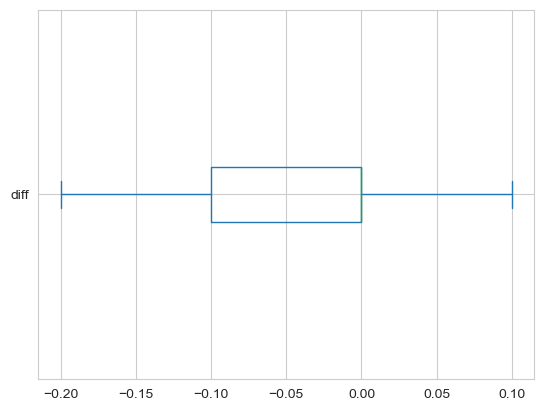

In [325]:
# Take data for "Total" people from both crude and aa dataframe
d3 = d1.loc[d1['stub_name'] == 'Total', ["year", "estimate"]].sort_values(by = ["year"]).add_suffix(suffix = '_crude')
d4 = d2.loc[d2['stub_name'] == 'Total', ["year", "estimate"]].sort_values(by = ["year"]).add_suffix(suffix = '_ageadjusted')

# Reset index helps ignore index when merge dfs
d3.reset_index(drop=True, inplace=True)
d4.reset_index(drop=True, inplace=True)

# Merge data from crude and aa df to compare the different between them
d5 = pd.concat([ d3,d4 ], axis = 1)

# Create "diff" column to see the offset between values from crude and aa data
d5["diff"] = d5["estimate_crude"] - d5["estimate_ageadjusted"]

d5['diff'].plot(kind = 'box', vert = False)

<Axes: ylabel='Frequency'>

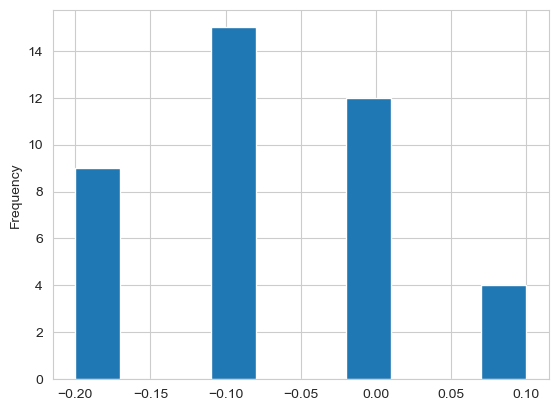

In [326]:
# THE SAME PROCESS WILL BE APPLIED TO "SEX" DATA
# Take data for "Sex" from both crude and aa dataframe
# Take data for "Sex" from both age-adjusted (d1) and crude (d2) dataframes
d3 = d1.loc[d1['stub_name'] == 'Sex', ["stub_label", "year", "estimate"]].sort_values(by=["year", "stub_label"]).add_suffix('_crude')
d4 = d2.loc[d2['stub_name'] == 'Sex', ["stub_label", "year", "estimate"]].sort_values(by=["year", "stub_label"]).add_suffix('_ageadjusted')

# Reset index for both dataframes
d3.reset_index(drop=True, inplace=True)
d4.reset_index(drop=True, inplace=True)

# Concatenate d3 and d4 along the columns
d5 = pd.concat([d3, d4], axis=1)

# Calculate the difference between the crude and age-adjusted estimates
d5["diff"] = d5["estimate_crude"] - d5["estimate_ageadjusted"]

# Plot a histogram of the differences
d5['diff'].plot(kind='hist')


In [327]:
# age-adjusted data
d1 = d1.loc[:, 
    ['stub_name', 'stub_name_num', 'stub_label', 'stub_label_num', 'year', 'year_num', 'age', 'age_num', 'estimate', 'flag']]

# crude data
d2 = d2.loc[:, 
    ['stub_name', 'stub_name_num', 'stub_label', 'stub_label_num', 'year', 'year_num', 'age', 'age_num', 'estimate', 'flag']]


In [328]:
# Import matplot library
import matplotlib.pyplot as plt 

# Utility functions 
    # --- Reduce repeated legend labels 
def simplifyLabels():
    handles, labels = plt.gca().get_legend_handles_labels() # --- extract labels from plt
    simple_labels = list(map(lambda l : l.split(', ')[1], labels)) # --- simplify labels
    by_label = dict(zip(simple_labels, handles)) # --- compress new label to plt
    plt.legend(by_label.values(), by_label.keys()) # --- add legend to the plot

### Q1. How have drug overdose fatality rates changed over time by gender, race, and age?

In [329]:
# Overall trend from 1999-2018
totalTrend = d2.loc[
    (d2["stub_name"] == 'Total') # Overall data
,["stub_label", "age","year", "estimate"]].sort_values(by = "year")

totalTrend.head()

,stub_label,age,year,estimate
420,All persons,All ages,1999,6
421,All persons,All ages,2000,6.2
422,All persons,All ages,2001,6.8
423,All persons,All ages,2002,8.2
424,All persons,All ages,2003,8.9


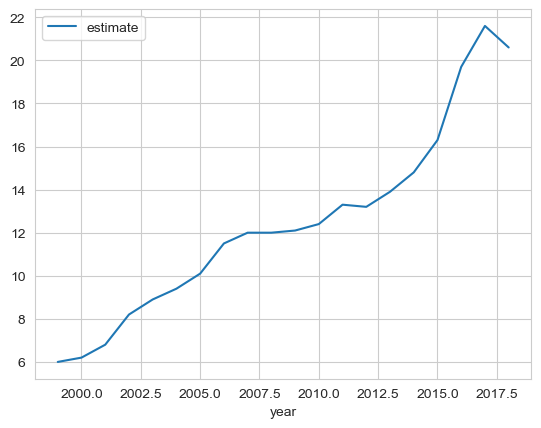

In [330]:
# Line Graph of overall trend from 1999-2018
totalTrend.plot(x='year', y='estimate')
plt.show()

### Q2. Which demographic group (gender, race, age) has the highest drug overdose death rate on average?

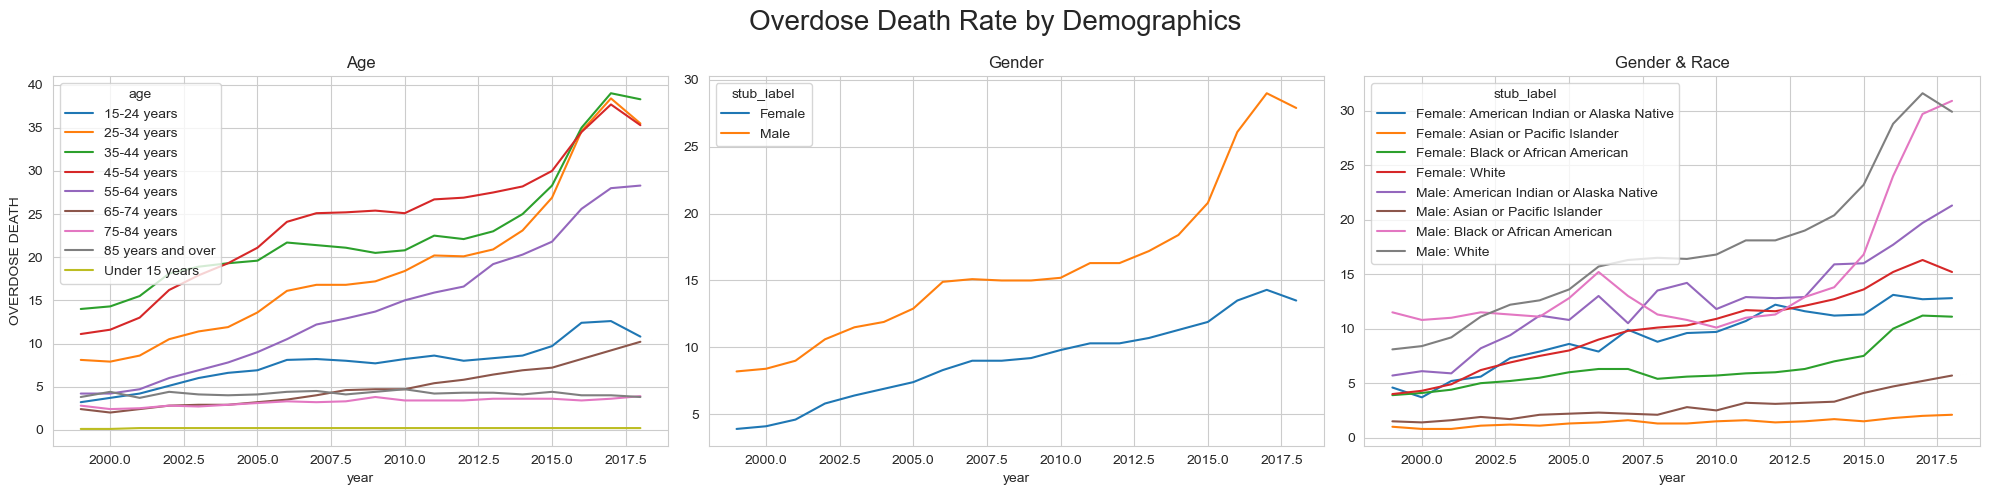

In [331]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming d1 and d2 are already filtered DataFrames from your actual data with the correct 'unit_num' values
# ...

# Death Rate by Age from 1999 - 2018
death_by_age = d2.query("stub_name == 'Age'").groupby(['year', 'age']).agg(Death_Rate=('estimate', 'sum'))

# Death rate by Gender from 1999 - 2018
death_by_gender = d2.query("stub_name == 'Sex'").groupby(['year', 'stub_label']).agg(Death_Rate=('estimate', 'sum'))

# Death rate by Race and Gender from 1999 - 2018
death_by_race = d1.query("stub_name == 'Sex and race'").groupby(['year', 'stub_label']).agg(Death_Rate=('estimate', 'sum'))

# Plotting data using matplotlib
fig, axs = plt.subplots(1, 3, figsize=(20, 5))  # align plots horizontally

# Plot for Death Rate by Age
death_by_age['Death_Rate'].unstack().plot(ax=axs[0])
axs[0].set_title('Age')
axs[0].set_ylabel('OVERDOSE DEATH')

# Plot for Death Rate by Gender
death_by_gender['Death_Rate'].unstack().plot(ax=axs[1])
axs[1].set_title('Gender')

# Plot for Death Rate by Race and Gender
death_by_race['Death_Rate'].unstack().plot(ax=axs[2])
axs[2].set_title('Gender & Race')

# Config aesthetic specs
fig.suptitle("Overdose Death Rate by Demographics", fontsize=20)
plt.tight_layout()

# Call the function to simplify legend labels if you've defined it in your script
# simplifyLabels()

plt.show()


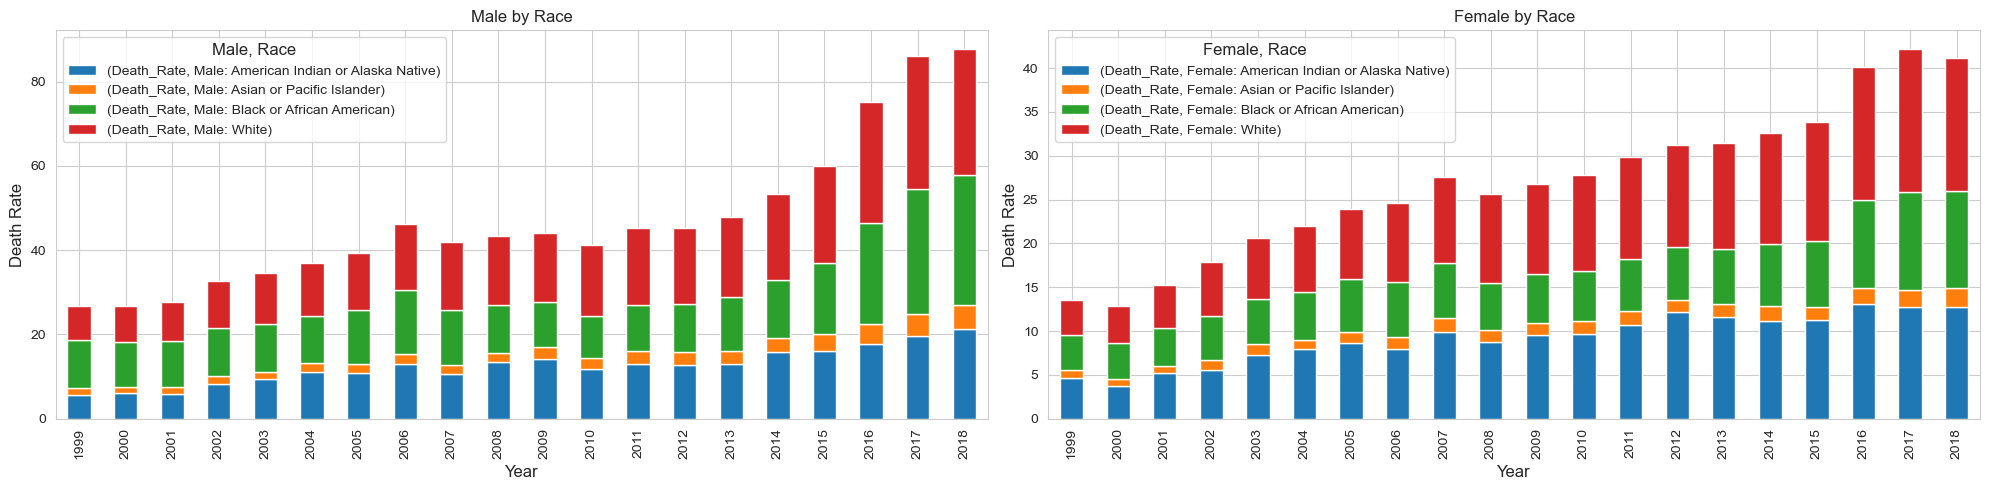

In [332]:
# Male racial groups
male_race = d1.loc[
    (d1["stub_name"] == 'Sex and race') &
    (d1["stub_label"].str.contains('Male'))
].groupby(['year', 'stub_label']).agg(Death_Rate=('estimate', 'sum')).unstack()

# Female racial groups
female_race = d1.loc[
    (d1["stub_name"] == 'Sex and race') &
    (d1["stub_label"].str.contains('Female'))
].groupby(['year', 'stub_label']).agg(Death_Rate=('estimate', 'sum')).unstack()

# Plot
fig, axs = plt.subplots(1, 2, figsize=(20, 5), dpi=100)  # Increase dpi for better clarity

# Male racial groups plot - thinner stacked bars
male_race.plot(kind='bar', stacked=True, ax=axs[0], title="Male by Race", width=0.5)
axs[0].set_ylabel('Death Rate', fontsize=12)
axs[0].set_xlabel('Year', fontsize=12)
axs[0].legend(title='Male, Race', fontsize=10, title_fontsize=12)

# Female racial groups plot - thinner stacked bars
female_race.plot(kind='bar', stacked=True, ax=axs[1], title="Female by Race", width=0.5)
axs[1].set_ylabel('Death Rate', fontsize=12)
axs[1].set_xlabel('Year', fontsize=12)
axs[1].legend(title='Female, Race', fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()


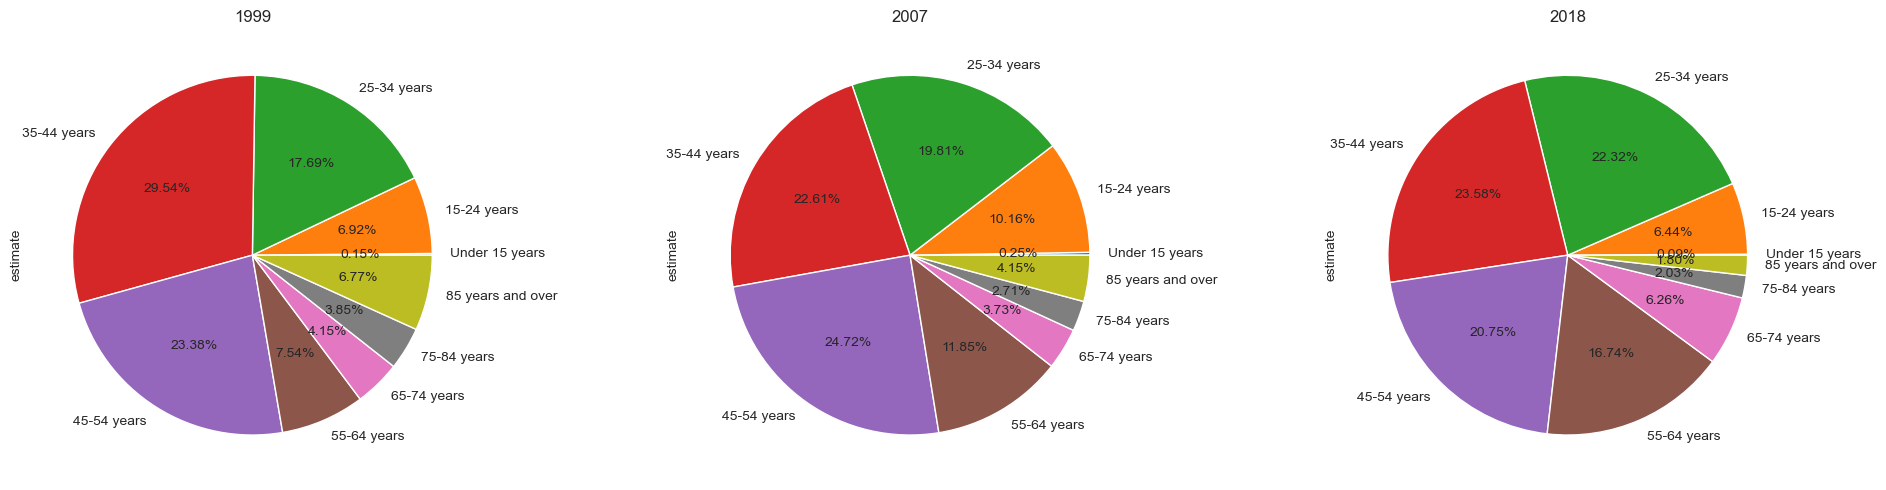

In [333]:
import matplotlib.pyplot as plt

# Assuming 'd2' is your DataFrame and includes a column like 'CAUSE' to filter by drug overdoses
# Adjust 'CAUSE' and the relevant string accordingly if it's named differently.

# Filter for drug overdose data
drug_overdose_data = d2.loc[
    (d2['stub_name'] == 'Sex and age') &
    (d2['stub_label'].str.contains('Male')),  # Adjust condition based on your data
    ['stub_label', 'year', 'age', 'estimate']
]

# Convert 'YEAR' to integer year if it's in datetime format
drug_overdose_data['year'] = pd.to_datetime(drug_overdose_data['year'], format='%Y')  # Adjust format as per your data

drug_overdose_data['year'] = drug_overdose_data['year'].dt.year


# Select data for specific years to compare
early_overdose = drug_overdose_data.loc[drug_overdose_data['year'] == 1999, ['age', 'estimate']]
middle_overdose = drug_overdose_data.loc[drug_overdose_data['year'] == 2007, ['age', 'estimate']]
late_overdose = drug_overdose_data.loc[drug_overdose_data['year'] == 2018, ['age', 'estimate']]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting the data
early_overdose.plot(ax=axs[0], kind='pie', y='estimate', labels=early_overdose['age'], legend=False, autopct="%.2f%%", title='1999')
middle_overdose.plot(ax=axs[1], kind='pie', y='estimate', labels=middle_overdose['age'], legend=False, autopct="%.2f%%", title='2007')
late_overdose.plot(ax=axs[2], kind='pie', y='estimate', labels=late_overdose['age'], legend=False, autopct="%.2f%%", title='2018')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


<Axes: title={'center': '2018'}, xlabel='age'>

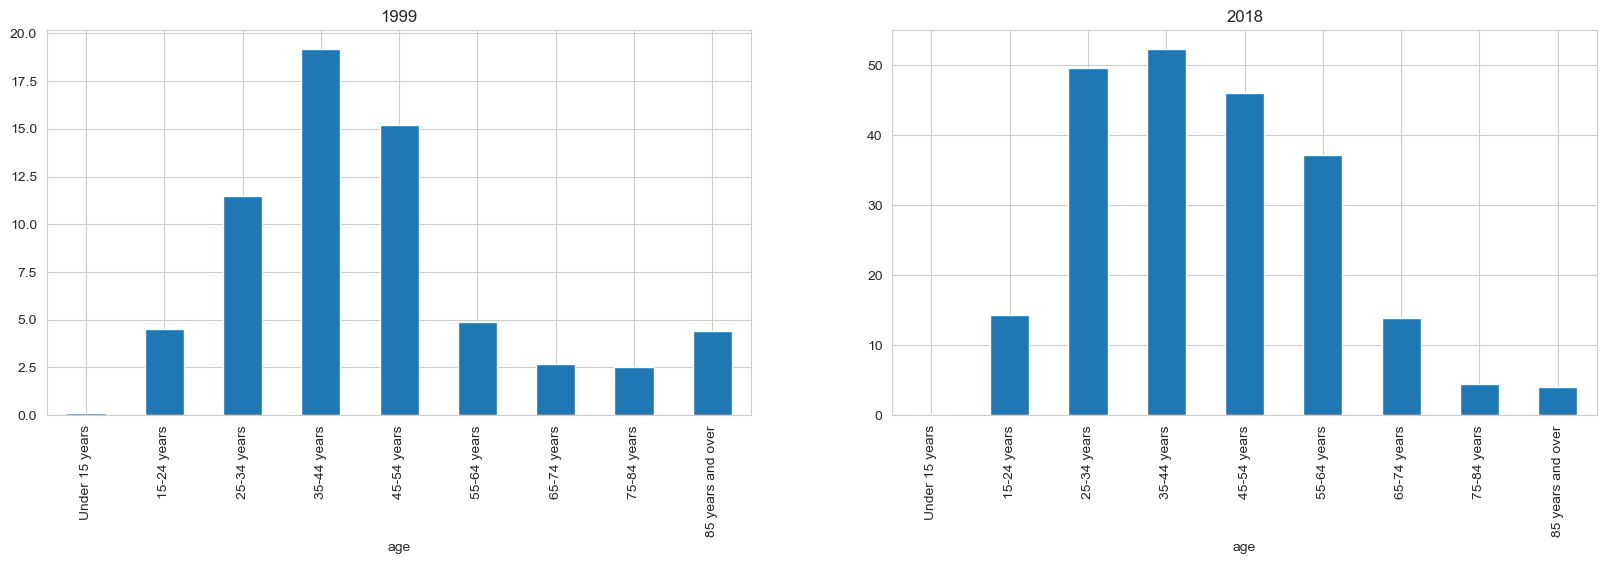

In [334]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
early_overdose.plot(ax=axs[0], kind = 'bar', y='estimate', x = 'age', legend = False, title = '1999')
late_overdose.plot(ax=axs[1], kind = 'bar', y='estimate', x = 'age', legend = False, title = '2018')

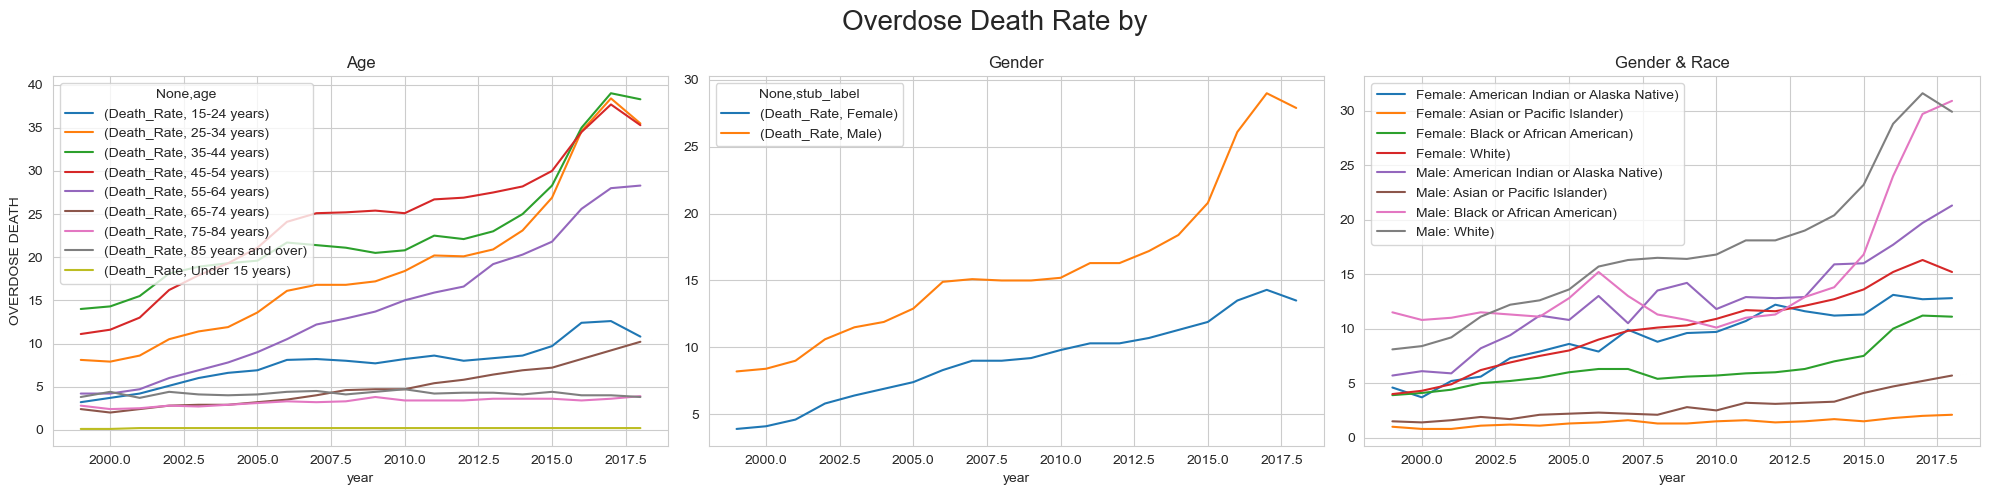

In [335]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5)) # --- align plots horizontally

death_by_age.unstack().plot(ax=axs[0], title = "Age",  ylabel = 'OVERDOSE DEATH')
death_by_gender.unstack().plot(ax=axs[1], title = "Gender")
death_by_race.unstack().plot(ax=axs[2], title = "Gender & Race")

# Config aesthetic specs
plt.suptitle("Overdose Death Rate by", fontsize = 20)
plt.tight_layout()
simplifyLabels()
plt.show()

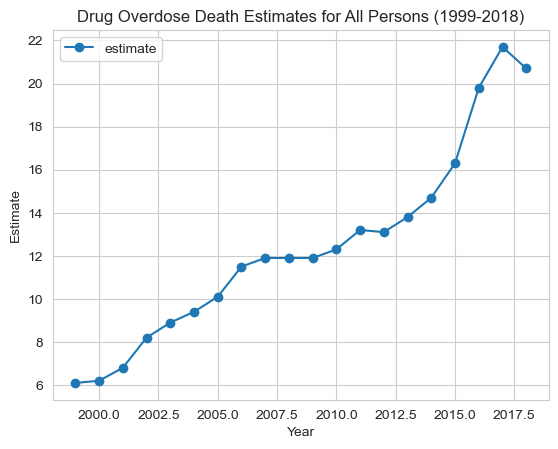

In [336]:
# Query the death estimate of all person from 1999 - 2018.
d1['year'] = pd.to_numeric(d1['year'], errors='coerce')

# Convert 'estimate' to numeric values, coercing errors to NaN which can be useful to avoid issues with non-numeric strings.
d1['estimate'] = pd.to_numeric(d1['estimate'], errors='coerce')

# Filter the rows where 'year' is between 1999 and 2018 and 'stub_label' is 'All persons'.
all_persons = d1.loc[
    (d1['year'] >= 1999) & (d1['year'] <= 2018) &
    (d1['stub_label'] == 'All persons'),
    ['year', 'estimate']
]

# Plotting
if not all_persons.empty and all_persons['estimate'].notna().any():
    all_persons.plot(x='year', y='estimate', marker='o', linestyle='-')
    plt.title('Drug Overdose Death Estimates for All Persons (1999-2018)')
    plt.xlabel('Year')
    plt.ylabel('Estimate')
    plt.grid(True)
    plt.show()
else:
    print("No data available to plot.")

In [337]:
# Adding a new field display the percentage change compared to the preceding year.
estimates = all_persons['estimate'].tolist()
changes_in_percent = [0]
for i in range(1, len(estimates)):
    percent_change = (estimates[i] / estimates[i-1])
    changes_in_percent.append(percent_change)

all_persons['CHANGE_PERCENTAGE'] = changes_in_percent
all_persons.sort_values(by = 'CHANGE_PERCENTAGE', ascending = False)

,year,estimate,CHANGE_PERCENTAGE
17,2016,19.8,1.214724
3,2002,8.2,1.205882
7,2006,11.5,1.138614
16,2015,16.3,1.108844
2,2001,6.8,1.096774
18,2017,21.7,1.095960
4,2003,8.9,1.085366
6,2005,10.1,1.074468
12,2011,13.2,1.073171
15,2014,14.7,1.065217


<Axes: xlabel='year'>

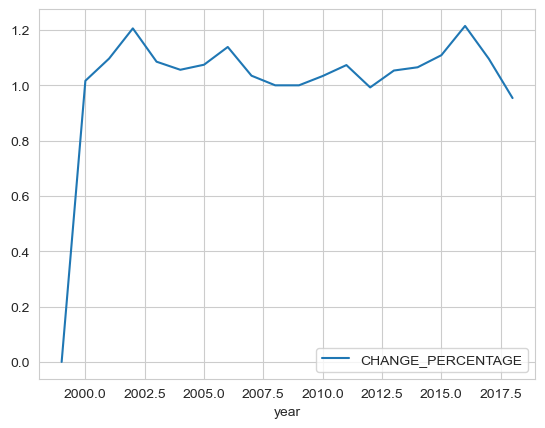

In [338]:
all_persons.plot(kind = 'line', x = 'year', y = 'CHANGE_PERCENTAGE')

#  Mongo DB To Postgres

In [236]:
import psycopg2

def create_database():
    conn = psycopg2.connect(
        user="dap",
        password="dap",
        host="localhost", 
        port="5432",
        database="postgres"  
    )
    conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
    cur = conn.cursor()

    # Create the HealthcareAnalyst database
    cur.execute("CREATE DATABASE HealthcareAnalyst;")
    print("Database 'HealthcareAnalyst' created successfully.")

    cur.close()
    conn.close()

create_database()


Database 'HealthcareAnalyst' created successfully.


In [238]:
import psycopg2

def create_tables():
    # Connect to the new database to create tables
    conn = psycopg2.connect(
        user="dap",
        password="dap",
        host="127.0.0.1",
        port="5432",
        database="healthcareanalyst"
    )
    cur = conn.cursor()

    # SQL statements to create tables
    tables_creation_sql = [
        """CREATE TABLE AppointmentDetailHA (
            id SERIAL PRIMARY KEY,
            PatientId BIGINT,
            AppointmentID BIGINT,
            Gender CHAR(1),
            ScheduledDay TIMESTAMP,
            AppointmentDay TIMESTAMP,
            Age INT,
            Neighbourhood VARCHAR(255),
            Scholarship BOOLEAN,
            Hypertension BOOLEAN,
            Diabetes BOOLEAN,
            Alcoholism BOOLEAN,
            Handicap BOOLEAN,
            SMS_received BOOLEAN,
            No_show BOOLEAN
        );""",
        """CREATE TABLE DeathRelatedDrugHA (
            id SERIAL PRIMARY KEY,
            CaseNumber VARCHAR(50),
            Date DATE,
            Sex VARCHAR(10),
            Race VARCHAR(50),
            Age INT,
            ResidenceCity VARCHAR(255),
            ResidenceState VARCHAR(255),
            ResidenceCounty VARCHAR(255),
            DeathCity VARCHAR(255),
            DeathState VARCHAR(255),
            DeathCounty VARCHAR(255),
            Location VARCHAR(255),
            DescriptionOfInjury TEXT,
            InjuryPlace VARCHAR(255),
            ImmediateCauseA TEXT,
            Heroin CHAR(1),
            Cocaine CHAR(1),
            Fentanyl CHAR(1),
            Oxycodone CHAR(1),
            Oxymorphone CHAR(1),
            EtOH CHAR(1),
            Hydrocodone CHAR(1),
            Benzodiazepine CHAR(1),
            Methadone CHAR(1)
        );""",
        """CREATE TABLE DrugsOverDoseHA (
            id SERIAL PRIMARY KEY,
            indicator VARCHAR(255),
            panel VARCHAR(255),
            panel_num INT,
            unit VARCHAR(255),
            unit_num INT,
            stub_name VARCHAR(255),
            stub_name_num INT,
            stub_label VARCHAR(255),
            stub_label_num NUMERIC,
            year INT,
            year_num NUMERIC,
            age VARCHAR(50),
            age_num NUMERIC,
            estimate NUMERIC,
            flag CHAR(1)
        );"""
    ]

    # Execute each command to create tables
    for sql_command in tables_creation_sql:
        cur.execute(sql_command)
    
    conn.commit()
    cur.close()
    conn.close()

    print("Tables created successfully.")

# Call the method to create tables
create_tables()


Tables created successfully.


In [271]:
import pymongo
import psycopg2

def to_numeric(value, default=None):
    """Converts a value to a float or returns a default if conversion fails or value is an empty string."""
    try:
        return float(value) if value != '' else default
    except (ValueError, TypeError):
        return default

def transfer_data_from_mongodb_to_postgresql(mongo_db_name, mongo_collection_name, pg_user, pg_password, pg_host, pg_port, pg_db_name, pg_table_name):
    try:
        # Connect to MongoDB
        mongo_client = pymongo.MongoClient('mongodb://localhost:27017/')
        mongo_db = mongo_client[mongo_db_name]
        mongo_collection = mongo_db[mongo_collection_name]

        # Connect to PostgreSQL
        pg_connection = psycopg2.connect(
            user=pg_user,
            password=pg_password,
            host=pg_host,
            port=pg_port,
            database=pg_db_name
        )
        pg_cursor = pg_connection.cursor()

        # Count the number of documents in MongoDB collection
        num_documents = mongo_collection.count_documents({})
        print(f"Number of documents retrieved from MongoDB: {num_documents}")

        # Check if there are no documents found
        if num_documents == 0:
            print("No documents found in MongoDB collection.")
            return

        # Query MongoDB collection
        cursor = mongo_collection.find()

        # Insert data into PostgreSQL
        num_inserted = 0
        for document in cursor:
            data_to_insert = (
                document.get('indicator', ''),
                document.get('panel', ''),
                int(document.get('panel_num', 0)),
                document.get('unit', ''),
                int(document.get('unit_num', 0)),
                document.get('stub_name', ''),
                int(document.get('stub_name_num', 0)),
                document.get('stub_label', ''),
                to_numeric(document.get('stub_label_num', None)),  # Allow NULL if empty
                int(document.get('year', 0)),
                to_numeric(document.get('year_num', None)),         # Allow NULL if empty
                document.get('age', ''),
                to_numeric(document.get('age_num', None)),         # Allow NULL if empty
                to_numeric(document.get('estimate', None)),        # Allow NULL if empty
                document.get('flag', '')
            )
            insert_query = f"""
                INSERT INTO {pg_table_name} (indicator, panel, panel_num, unit, unit_num, stub_name, stub_name_num, stub_label, stub_label_num, year, year_num, age, age_num, estimate, flag)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """
            pg_cursor.execute(insert_query, data_to_insert)
            num_inserted += 1

        # Commit the transaction
        pg_connection.commit()
        
        print("Data successfully transferred from MongoDB to PostgreSQL.")
        print(f"Number of rows inserted into PostgreSQL: {num_inserted}")

    except Exception as e:
        print(f"Error while transferring data: {str(e)}")
    finally:
        # Properly close all connections and cursors
        if pg_cursor:
            pg_cursor.close()
        if pg_connection:
            pg_connection.close()
        if mongo_client:
            mongo_client.close()

# Example usage
transfer_data_from_mongodb_to_postgresql(
    mongo_db_name='HealthCare',
    mongo_collection_name='DrugsOverDose',
    pg_user='dap',
    pg_password='dap',
    pg_host='127.0.0.1',
    pg_port='5432',
    pg_db_name='healthcareanalyst',
    pg_table_name='drugsoverdoseha'
)


Number of documents retrieved from MongoDB: 6228
Data successfully transferred from MongoDB to PostgreSQL.
Number of rows inserted into PostgreSQL: 6228


In [274]:
import pymongo
import psycopg2
from datetime import datetime

def to_char(value):
    """Ensures that only valid 'Y' values are converted to 'Y', everything else defaults to 'N'."""
    return 'Y' if value.strip().upper() == 'Y' else 'N'

def convert_date(date_str):
    """Converts a date string from 'DD/MM/YYYY' to 'YYYY-MM-DD'."""
    try:
        return datetime.strptime(date_str, '%d/%m/%Y').strftime('%Y-%m-%d')
    except ValueError:
        return None  # Return None if date is invalid

def safe_int(value, default=0):
    """Converts a value to an integer or returns a default if conversion fails."""
    try:
        return int(value)
    except (ValueError, TypeError):
        return default

def transfer_data_from_mongodb_to_postgresql(mongo_db_name, mongo_collection_name, pg_user, pg_password, pg_host, pg_port, pg_db_name, pg_table_name):
    mongo_client = None
    pg_connection = None
    pg_cursor = None
    try:
        # Connect to MongoDB
        mongo_client = pymongo.MongoClient('mongodb://localhost:27017/')
        mongo_db = mongo_client[mongo_db_name]
        mongo_collection = mongo_db[mongo_collection_name]

        # Connect to PostgreSQL
        pg_connection = psycopg2.connect(
            user=pg_user,
            password=pg_password,
            host=pg_host,
            port=pg_port,
            database=pg_db_name
        )
        pg_cursor = pg_connection.cursor()

        # Query MongoDB collection
        cursor = mongo_collection.find()

        # Insert data into PostgreSQL
        num_inserted = 0
        for document in cursor:
            data_to_insert = (
                document.get('CaseNumber', ''),
                convert_date(document.get('Date', '')),
                document.get('Sex', ''),
                document.get('Race', ''),
                safe_int(document.get('Age')),  
                document.get('ResidenceCity', ''),
                document.get('ResidenceState', ''),
                document.get('ResidenceCounty', ''),
                document.get('DeathCity', ''),
                document.get('DeathState', ''),
                document.get('DeathCounty', ''),
                document.get('Location', ''),
                document.get('DescriptionOfInjury', ''),
                document.get('InjuryPlace', ''),
                document.get('ImmediateCauseA', ''),
                to_char(document.get('Heroin', 'N')),
                to_char(document.get('Cocaine', 'N')),
                to_char(document.get('Fentanyl', 'N')),
                to_char(document.get('Oxycodone', 'N')),
                to_char(document.get('Oxymorphone', 'N')),
                to_char(document.get('EtOH', 'N')),
                to_char(document.get('Hydrocodone', 'N')),
                to_char(document.get('Benzodiazepine', 'N')),
                to_char(document.get('Methadone', 'N'))
            )
            insert_query = f"""
                INSERT INTO {pg_table_name} (CaseNumber, Date, Sex, Race, Age, ResidenceCity, ResidenceState, ResidenceCounty, DeathCity, DeathState, DeathCounty, Location, DescriptionOfInjury, InjuryPlace, ImmediateCauseA, Heroin, Cocaine, Fentanyl, Oxycodone, Oxymorphone, EtOH, Hydrocodone, Benzodiazepine, Methadone)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """
            pg_cursor.execute(insert_query, data_to_insert)
            num_inserted += 1

        # Commit the transaction
        pg_connection.commit()
        
        print("Data successfully transferred from MongoDB to PostgreSQL.")
        print(f"Number of rows inserted into PostgreSQL: {num_inserted}")

    except Exception as e:
        print(f"Error while transferring data: {str(e)}")
    finally:
        # Properly close all connections and cursors
        if pg_cursor:
            pg_cursor.close()
        if pg_connection:
            pg_connection.close()
        if mongo_client:
            mongo_client.close()

# Example usage
transfer_data_from_mongodb_to_postgresql(
    mongo_db_name='HealthCare',
    mongo_collection_name='DeathRelatedDrug',
    pg_user='dap',
    pg_password='dap',
    pg_host='127.0.0.1',
    pg_port='5432',
    pg_db_name='healthcareanalyst',
    pg_table_name='deathrelateddrugha'
)

Data successfully transferred from MongoDB to PostgreSQL.
Number of rows inserted into PostgreSQL: 4081


In [280]:
import pymongo
import psycopg2
from datetime import datetime

def convert_to_boolean(value):
    """Converts an integer value from MongoDB to a boolean."""
    return bool(value)

def convert_to_timestamp(date_str):
    """Converts ISO date string from MongoDB to a PostgreSQL timestamp format."""
    for fmt in ('%Y-%m-%dT%H:%M:%S.%fZ', '%Y-%m-%dT%H:%M:%SZ'):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format for '{date_str}' is not supported.")

def transfer_data_from_mongodb_to_postgresql(mongo_db_name, mongo_collection_name, pg_user, pg_password, pg_host, pg_port, pg_db_name, pg_table_name):
    mongo_client = None
    pg_connection = None
    pg_cursor = None
    try:
        # Connect to MongoDB
        mongo_client = pymongo.MongoClient('mongodb://localhost:27017/')
        mongo_db = mongo_client[mongo_db_name]
        mongo_collection = mongo_db[mongo_collection_name]
        print(f"Accessing MongoDB Collection: {mongo_collection_name}")

        # Connect to PostgreSQL and create cursor
        try:
            pg_connection = psycopg2.connect(
                user=pg_user,
                password=pg_password,
                host=pg_host,
                port=pg_port,
                database=pg_db_name
            )
            pg_cursor = pg_connection.cursor()
        except Exception as e:
            print(f"Failed to connect to PostgreSQL or create cursor: {str(e)}")
            return

        # Query MongoDB collection
        cursor = mongo_collection.find()
        num_inserted = 0
        for document in cursor:
            data_to_insert = (
                int(document.get('PatientId', 0)),
                int(document.get('AppointmentID', 0)),
                document.get('Gender', '').strip(),
                convert_to_timestamp(document['ScheduledDay']),
                convert_to_timestamp(document['AppointmentDay']),
                int(document.get('Age', 0)),
                document.get('Neighbourhood', ''),
                convert_to_boolean(document.get('Scholarship', 0)),
                convert_to_boolean(document.get('Hypertension', 0)),
                convert_to_boolean(document.get('Diabetes', 0)),
                convert_to_boolean(document.get('Alcoholism', 0)),
                convert_to_boolean(document.get('Handicap', 0)),
                convert_to_boolean(document.get('SMS_received', 0)),
                document.get('No_show', 'No') == 'Yes'
            )
            try:
                insert_query = f"""
                    INSERT INTO {pg_table_name} (PatientId, AppointmentID, Gender, ScheduledDay, AppointmentDay, Age, Neighbourhood, Scholarship, Hypertension, Diabetes, Alcoholism, Handicap, SMS_received, No_show)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """
                pg_cursor.execute(insert_query, data_to_insert)
                num_inserted += 1
            except Exception as e:
                print(f"Failed to execute insert: {str(e)}")
                break  

        # Commit the transaction
        pg_connection.commit()
        print("Data successfully transferred from MongoDB to PostgreSQL.")
        print(f"Number of rows inserted into PostgreSQL: {num_inserted}")

    except Exception as e:
        print(f"Error during processing: {str(e)}")
    finally:
        # Properly close all connections and cursors
        if pg_cursor:
            pg_cursor.close()
        if pg_connection:
            pg_connection.close()
        if mongo_client:
            mongo_client.close()

# Example usage
transfer_data_from_mongodb_to_postgresql(
    mongo_db_name='HealthCare',
    mongo_collection_name='AppointmentDetails',
    pg_user='dap',
    pg_password='dap',
    pg_host='127.0.0.1',
    pg_port='5432',
    pg_db_name='healthcareanalyst',
    pg_table_name='appointmentdetailha'
)


Accessing MongoDB Collection: AppointmentDetails
Data successfully transferred from MongoDB to PostgreSQL.
Number of rows inserted into PostgreSQL: 110527


In [291]:
pip install pandas sqlalchemy psycopg2


Note: you may need to restart the kernel to use updated packages.


In [292]:
from sqlalchemy import create_engine
import pandas as pd

# Set up the connection to PostgreSQL using SQLAlchemy
username = 'dap'
password = 'dap'
host = '127.0.0.1'
port = '5432'
database = 'healthcareanalyst'

# Create the connection URL
connection_url = f"postgresql://{username}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_url)



#### 1. Trend Analysis of Drug Overdose Deaths Over Years

In [296]:
query = """
SELECT year, AVG(estimate) as average_death_rate
FROM drugsoverdoseha
GROUP BY year
ORDER BY year;
"""
df = pd.read_sql(query, engine)
print(df)


    year  average_death_rate
0   1999            2.305714
1   2000            2.300939
2   2001            2.433333
3   2002            2.864957
4   2003            3.125214
5   2004            3.276987
6   2005            3.459514
7   2006            3.957831
8   2007            4.063200
9   2008            4.064615
10  2009            4.249425
11  2010            4.328405
12  2011            4.546565
13  2012            4.571805
14  2013            4.946008
15  2014            5.457678
16  2015            6.139259
17  2016            7.756618
18  2017            8.574910
19  2018            8.601105


#### 2. Non-Attendance Rates by Age and Gender

In [297]:
query = """
SELECT Age, Gender, COUNT(*) as total_appointments, 
SUM(CASE WHEN No_show = TRUE THEN 1 ELSE 0 END) as no_shows
FROM appointmentdetailha
GROUP BY Age, Gender;
"""
df = pd.read_sql(query, engine)
print(df)


     age gender  total_appointments  no_shows
0     80      F                 355         0
1     67      M                 310         0
2      1      M                1185         0
3     28      F                1086         0
4     44      F                 991         0
..   ...    ...                 ...       ...
199   17      F                1022         0
200   85      F                 194         0
201   13      M                 541         0
202   33      M                 426         0
203   10      F                 569         0

[204 rows x 4 columns]


#### 3. Correlation Between Drug Overdose Deaths and Specific Drugs

In [304]:
# SQL query using the corrected columns
query = """
SELECT EXTRACT(YEAR FROM date) AS year, 
       SUM(CASE WHEN oxycodone = 'Y' THEN 1 ELSE 0 END) AS oxycodone_deaths,
       SUM(CASE WHEN hydrocodone = 'Y' THEN 1 ELSE 0 END) AS hydrocodone_deaths
FROM deathrelateddrugha
GROUP BY EXTRACT(YEAR FROM date);
"""

# Executing the query and loading the data into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Display the results
print(df)

     year  oxycodone_deaths  hydrocodone_deaths
0     NaN               309                  63
1  2016.0                40                  11
2  2012.0                21                   5
3  2015.0                43                   8
4  2017.0                45                   3
5  2013.0                27                   8
6  2014.0                45                   6


#### 4. Demographic Analysis of Overdose Deaths

In [305]:
query = """
SELECT Race, AVG(Age) as average_age, COUNT(*) as death_count
FROM deathrelateddrugha
GROUP BY Race;
"""
df = pd.read_sql(query, engine)
print(df)


                      race  average_age  death_count
0                 Hawaiian    58.000000            1
1   Native American, Other    44.000000            1
2                    Other    37.285714            7
3                  Unknown    39.375000           16
4          Hispanic, White    42.707657          431
5                             42.000000           11
6                  Chinese    24.000000            2
7          Hispanic, Black    40.588235           17
8                    White    41.184089         3243
9             Asian Indian    33.777778            9
10            Asian, Other    35.071429           14
11                   Black    46.775076          329
